# NARMA-L2 Neural Network Controller for Anti-Lock Braking System (ABS)

**Author:** Martin Astyan\
**Course:** Architecture of Intelligent Transport Systems - 2025

---

## Table of Contents
**I - Project Overview**
1. Project Objectives
2.  Scientific Background
3. Methodology

**II - Code**
1. Import Libraries and Setup
2. ABS System Modeling
3. Training Data Generation
4. NARMA-L2 Controller Implementation

---

## I - Project Overview
This notebook implements a Neural Network-based Feedback Linearization (NARMA-L2) slip controller for an Anti-Lock Braking System (ABS), based on the research paper: [Neural Network Based Feedback Linearisation Slip Control of an Anti-Lock Braking System"
J. O Pedro, O. T. C Nyandoro, S John
7th Asian Control Conference, Hong Kong, China, August 27-29, 2009](https://ieeexplore.ieee.org/document/5276197)

### 1. Project Objectives

The main objectives are to simulate ABS dynamics using a quarter-car model with electro-mechanical braking system and then generate synthetic training data for neural network training. The final goal is to implement the NARMA-L2 controller to maintain an optimal slip ratio and compare performance with traditional PID controllers.

### 2.  Scientific Background
The NARMA-L2 (Nonlinear Autoregressive Moving Average with exogenous inputs - Level 2) controller transforms nonlinear system dynamics into linear dynamics by cancelling nonlinearities. The key equation from the paper (Equation 14, page 1254) is:\
$y(k+d) = f(·) + g(·) \times u(k+1)$

Where:

- $f(·)$: Nonlinear function depending on past outputs and inputs
- $g(·)$: Function approximating system sensitivity to control input
- $u(k+1)$: Future control command
- $y(k+d)$: Future system output (slip ratio)

### 3. Methodology
The implementation follows a specific training strategy:

- Step 1: Generate synthetic ABS data using quarter-car model
- Step 2: Train g-network first (system sensitivity)
- Step 3: Calculate corrected targets for f-network: $f_k = y(k+1) - g_k · u(k+1)$
- Step 4: Train f-network with corrected targets
- Step 5: Implement NARMA-L2 control law for slip regulation

## II- Code
### 1. Import Libraries and Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### 2. ABS System Modeling
#### 2.1 Quarter-Car Model Implementation
The ABS system is modeled using a quarter-car approach as described in the paper. The mathematical model includes:

$\begin{align}
\text{Vehicle dynamics:} \quad & M \cdot \dot{v} = -\mu(\lambda) F_z - C_x \cdot v^2 \\
\text{Wheel rotational dynamics:} \quad & I \cdot \dot{\omega} = \mu(\lambda) F_z \cdot r - B \cdot \omega - \tau_b \\
\text{Electro-mechanical brake system:} \quad & \dot{\tau}_b = \frac{-\tau_b + K_b \cdot v_b}{\tau}
\end{align}$

In [9]:
class ABSSystemSimulator:
    """
    ABS System Simulator based on quarter-car model from the paper
    Generates synthetic data for neural network training

    References the mathematical model from equations (1)-(7) in the paper
    """

    def __init__(self):
        # Model parameters from Table I of the paper
        self.M = 440        # Total mass (kg)
        self.I = 1.6        # Wheel moment of inertia (kg⋅m²)
        self.r = 0.3        # Wheel radius (m)
        self.B = 0.08       # Rolling friction coefficient (kg⋅m²/s)
        self.Cx = 0.856     # Aerodynamic friction coefficient (kg/m)
        self.Kb = 0.8       # Braking gain
        self.tau = 0.003    # Electro-mechanical system time constant (s)
        self.g = 9.81       # Gravitational acceleration (m/s²)
        self.Fz = self.M * self.g  # Normal force

        # Road surface parameters (dry asphalt)
        self.mu0 = 0.9      # Maximum friction coefficient
        self.lambda0 = 0.25 # Optimal slip ratio

    def friction_model(self, slip_ratio):
        """
        μ-λ friction model according to equation (6) from the paper

        μ(λ) = (2μ₀λ₀λ) / (λ₀² + λ²)

        This model represents the tire-road friction characteristic
        that peaks at the optimal slip ratio λ₀
        """
        lambda_val = np.abs(slip_ratio)
        mu = (2 * self.mu0 * self.lambda0 * lambda_val) / (self.lambda0**2 + lambda_val**2)
        return mu

    def system_dynamics(self, state, t, control_input):
        """
        System dynamics according to equations (7) from the paper

        State vector: [ω, v, τb]
        - ω: wheel angular velocity
        - v: vehicle velocity
        - τb: braking torque
        """
        omega, v, tau_b = state

        # Calculate slip ratio - avoid division by zero
        if v > 0.5:
            slip_ratio = (v - self.r * omega) / v
        else:
            slip_ratio = 0

        # Friction coefficient from μ-λ curve
        mu = self.friction_model(slip_ratio)

        # System differential equations
        domega_dt = (mu * self.Fz * self.r / self.I) - (self.B * omega / self.I) - (tau_b / self.I)
        dv_dt = -(mu * self.Fz / self.M) - (self.Cx * v**2 / self.M)
        dtau_b_dt = (-tau_b + self.Kb * control_input) / self.tau

        return [domega_dt, dv_dt, dtau_b_dt]

    def generate_training_data(self, n_scenarios=50, duration=5.0, dt=0.01, controlled=True):
        """
        Generate training data using a filtered PID controller (with α) if controlled=True.
        The controller attempts to regulate the slip_ratio near lambda0.
        """
        time_points = np.arange(0, duration, dt)
        all_data = []

        for scenario in range(n_scenarios):
            # Initial conditions
            v0 = np.random.uniform(20, 40)
            initial_slip = np.random.uniform(0.1, 0.4)
            omega0 = v0 * (1 - initial_slip) / self.r  # Ensures positive slip
            tau_b0 = np.random.uniform(0, 20)
            state = [omega0, v0, tau_b0]
            trajectory = []

            # PID controller setup
            if controlled:
                pid = PIDController(Kp=3000, Ti=0.1, Td=0.01, alpha=0.1, dt=dt)

            for i, t in enumerate(time_points):
                omega, v, tau_b = state
                if v > 0.1:
                    slip_ratio = (v - self.r * omega) / v
                    #slip_ratio = (v - self.r * omega) / v + np.random.normal(0, 0.0005)

                else:
                    slip_ratio = 0

                mu = self.friction_model(slip_ratio)

                # Choose control mode
                if controlled:
                    error = self.lambda0 - slip_ratio
                    vb_control = pid.compute(error)

                # Simulate dynamics
                if i > 0:
                    state = odeint(self.system_dynamics, state, [time_points[i-1], t], args=(vb_control,))[1]

                omega, v, tau_b = state

                if v > 0.1:
                    slip_ratio = (v - self.r * omega) / v
                else:
                    slip_ratio = 0

                data_point = {
                    'time': t,
                    'scenario': scenario,
                    'omega': omega,
                    'v': v,
                    'tau_b': tau_b,
                    'control_input': vb_control,
                    'slip_ratio': slip_ratio,
                    'mu': mu,
                    'slip_k_1': 0 if i == 0 else trajectory[i-1]['slip_ratio'],
                    'slip_k_2': 0 if i < 2 else trajectory[i-2]['slip_ratio'],
                    'control_k_1': 0 if i == 0 else trajectory[i-1]['control_input'],
                    'control_k_2': 0 if i < 2 else trajectory[i-2]['control_input']
                }

                trajectory.append(data_point)
                all_data.append(data_point)

                if v < 0.5:
                    break

        return pd.DataFrame(all_data)

# Create simulator instance
simulator = ABSSystemSimulator()

#### 2.2 PID Controller
The structure of the PID controller is given as described in the paper:
$U(s) = K_P \cdot (\frac{1 + T_D s}{1 + \alpha T_D s} \cdot \frac{1 + T_I s}{T_I s}) \cdot E(s)$

where :
- $E(s) = Y_{ref} (s) − Y (s)$ is the error signal between the reference signal $Y_{ref} (s)$ and the actual output signal $Y (s)$
- $U (s)$ is the plant input signal
- $K_P$ is the proportional gain
- $T_D$ is the derivative time constant
- $T_I$ is the integral time constant
- $\alpha$ is the lag factor in the derivative component of the PID controller


In [10]:
class PIDController:
    def __init__(self, Kp, Ti, Td, alpha, dt):
        self.Kp = Kp        # Proportional gain
        self.Ti = Ti        # Integral time constant
        self.Td = Td        # Derivative time constant
        self.alpha = alpha  # Derivative filter parameter
        self.dt = dt        # Sampling time

        self.integral = 0.0     # Integral accumulator
        self.e_prev = 0.0       # Previous error
        self.d_filtered = 0.0   # Filtered derivative

    def compute(self, error):
        # Update integral (from (1 + T_Is)/T_Is)
        self.integral += error * self.dt

        # Compute raw derivative
        raw_derivative = (error - self.e_prev) / self.dt
        self.d_filtered = (self.alpha * self.Td * self.d_filtered + raw_derivative * self.dt) / (self.alpha * self.Td + self.dt)

        # Final control output (multiplicative structure)
        u = self.Kp * (error + (self.integral / self.Ti) + self.Td * self.d_filtered)

        # Store current error for next cycle
        self.e_prev = error

        # Apply output saturation
        return np.clip(u, 0, 1800)

#### 2.3 Friction Model Visualization
Let's visualize the $\mu - \lambda$ curve that is central to ABS control:

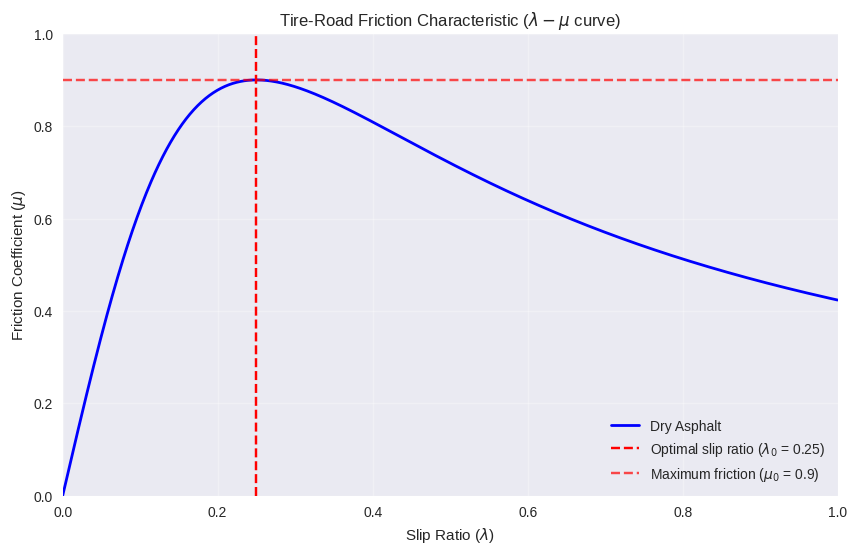

Optimal slip ratio: 0.25
Maximum friction coefficient: 0.9


In [11]:
# Generate slip ratio values
slip_ratios = np.linspace(0, 1, 1000)
friction_coeffs = [simulator.friction_model(sr) for sr in slip_ratios]

plt.figure(figsize=(10, 6))
plt.plot(slip_ratios, friction_coeffs, 'b-', linewidth=2, label='Dry Asphalt')
plt.axvline(x=simulator.lambda0, color='r', linestyle='--',
           label=f'Optimal slip ratio ($\lambda_0$ = {simulator.lambda0})')
plt.axhline(y=simulator.mu0, color='r', linestyle='--', alpha=0.7,
           label=f'Maximum friction ($\mu_0$ = {simulator.mu0})')
plt.xlabel('Slip Ratio ($\lambda$)')
plt.ylabel('Friction Coefficient ($\mu$)')
plt.title('Tire-Road Friction Characteristic ($\lambda-\mu$ curve)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

print(f"Optimal slip ratio: {simulator.lambda0}")
print(f"Maximum friction coefficient: {simulator.mu0}")

### 3. Training Data Generation
#### 3.1 Generate Synthetic ABS Data

In [12]:
print("Generating training data...")
# Generate training data (adjust n_scenarios as needed)
training_data = simulator.generate_training_data(n_scenarios=50, duration=4.0)

print(f"Generated data: {len(training_data)} points")
print(f"Number of scenarios: {training_data['scenario'].nunique()}")
print(f"Time range: {training_data['time'].min():.2f} - {training_data['time'].max():.2f} seconds")

# Display first few rows
print("\nFirst few data points:")
print(training_data.head())

Generating training data...
Generated data: 16015 points
Number of scenarios: 50
Time range: 0.00 - 3.92 seconds

First few data points:
   time  scenario      omega          v       tau_b  control_input  \
0  0.00         0  71.255664  32.760118    7.269969       0.000000   
1  0.01         0  78.292695  32.653396    0.259349       0.000000   
2  0.02         0  85.439059  32.544729   15.568458      20.168498   
3  0.03         0  91.353422  32.440471  200.289248     258.903444   
4  0.04         0  95.448109  32.346907  339.596557     430.937561   

   slip_ratio        mu  slip_k_1  slip_k_2  control_k_1  control_k_2  
0    0.347478  0.853331  0.000000  0.000000     0.000000     0.000000  
1    0.280693  0.853331  0.347478  0.000000     0.000000     0.000000  
2    0.212416  0.893999  0.280693  0.347478     0.000000     0.000000  
3    0.155190  0.888187  0.212416  0.280693    20.168498     0.000000  
4    0.114771  0.806565  0.155190  0.212416   258.903444    20.168498  


#### 3.2 Data Quality Analysis

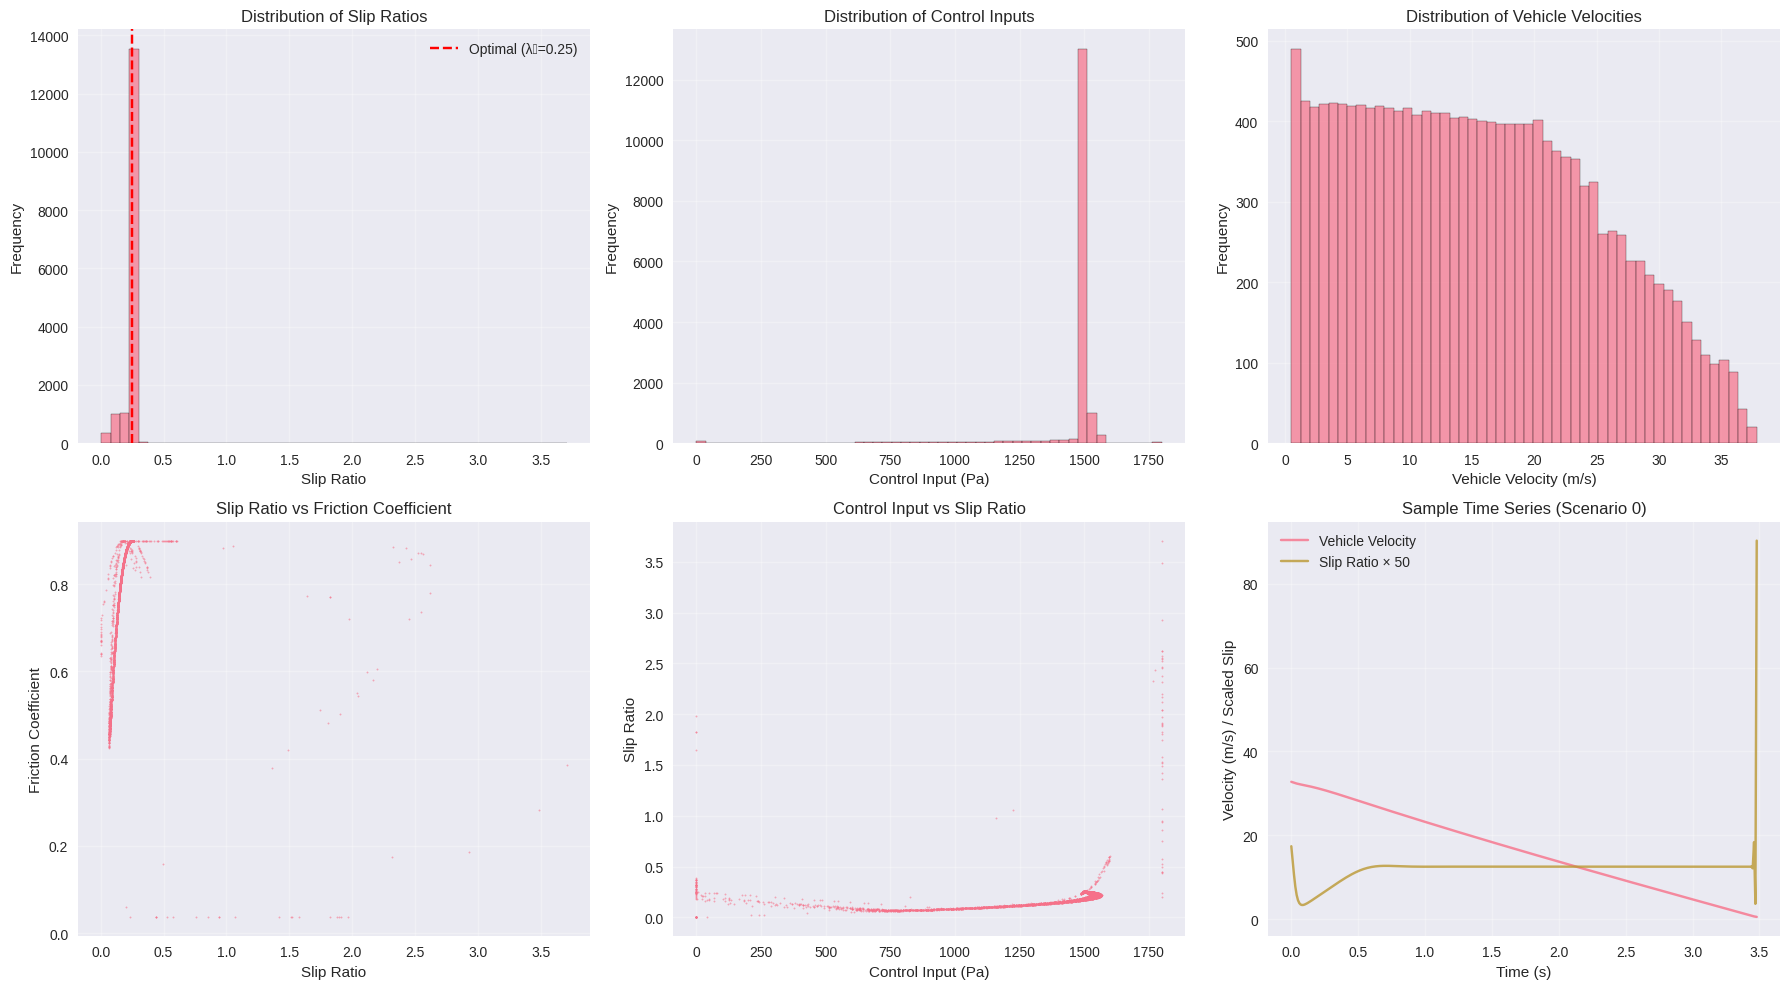

Data Quality Statistics:
Total data points: 16015
Slip ratio range: [0.005, 3.707]
Control input range: [0.0, 1800.0] Pa
Velocity range: [0.5, 37.8] m/s
Missing values: 0


In [13]:
def analyze_data_quality(df):
    """Analyze the quality and characteristics of generated data"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Slip ratio distribution
    axes[0,0].hist(df['slip_ratio'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,0].axvline(simulator.lambda0, color='red', linestyle='--',
                     label=f'Optimal (λ₀={simulator.lambda0})')
    axes[0,0].set_xlabel('Slip Ratio')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].set_title('Distribution of Slip Ratios')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. Control input distribution
    axes[0,1].hist(df['control_input'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,1].set_xlabel('Control Input (Pa)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Control Inputs')
    axes[0,1].grid(True, alpha=0.3)

    # 3. Velocity distribution
    axes[0,2].hist(df['v'], bins=50, alpha=0.7, edgecolor='black')
    axes[0,2].set_xlabel('Vehicle Velocity (m/s)')
    axes[0,2].set_ylabel('Frequency')
    axes[0,2].set_title('Distribution of Vehicle Velocities')
    axes[0,2].grid(True, alpha=0.3)

    # 4. Slip vs Friction
    axes[1,0].scatter(df['slip_ratio'], df['mu'], alpha=0.5, s=1)
    axes[1,0].set_xlabel('Slip Ratio')
    axes[1,0].set_ylabel('Friction Coefficient')
    axes[1,0].set_title('Slip Ratio vs Friction Coefficient')
    axes[1,0].grid(True, alpha=0.3)

    # 5. Control vs Slip relationship
    axes[1,1].scatter(df['control_input'], df['slip_ratio'], alpha=0.5, s=1)
    axes[1,1].set_xlabel('Control Input (Pa)')
    axes[1,1].set_ylabel('Slip Ratio')
    axes[1,1].set_title('Control Input vs Slip Ratio')
    axes[1,1].grid(True, alpha=0.3)

    # 6. Time series of velocity and slip for one scenario
    scenario_data = df[df['scenario'] == 0]
    axes[1,2].plot(scenario_data['time'], scenario_data['v'], label='Vehicle Velocity', alpha=0.8)
    axes[1,2].plot(scenario_data['time'], scenario_data['slip_ratio'] * 50,
                  label='Slip Ratio × 50', alpha=0.8)
    axes[1,2].set_xlabel('Time (s)')
    axes[1,2].set_ylabel('Velocity (m/s) / Scaled Slip')
    axes[1,2].set_title('Sample Time Series (Scenario 0)')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("Data Quality Statistics:")
    print(f"Total data points: {len(df)}")
    print(f"Slip ratio range: [{df['slip_ratio'].min():.3f}, {df['slip_ratio'].max():.3f}]")
    print(f"Control input range: [{df['control_input'].min():.1f}, {df['control_input'].max():.1f}] Pa")
    print(f"Velocity range: [{df['v'].min():.1f}, {df['v'].max():.1f}] m/s")
    print(f"Missing values: {df.isnull().sum().sum()}")

analyze_data_quality(training_data)

#### 3.3 Sample Scenarios Visualization

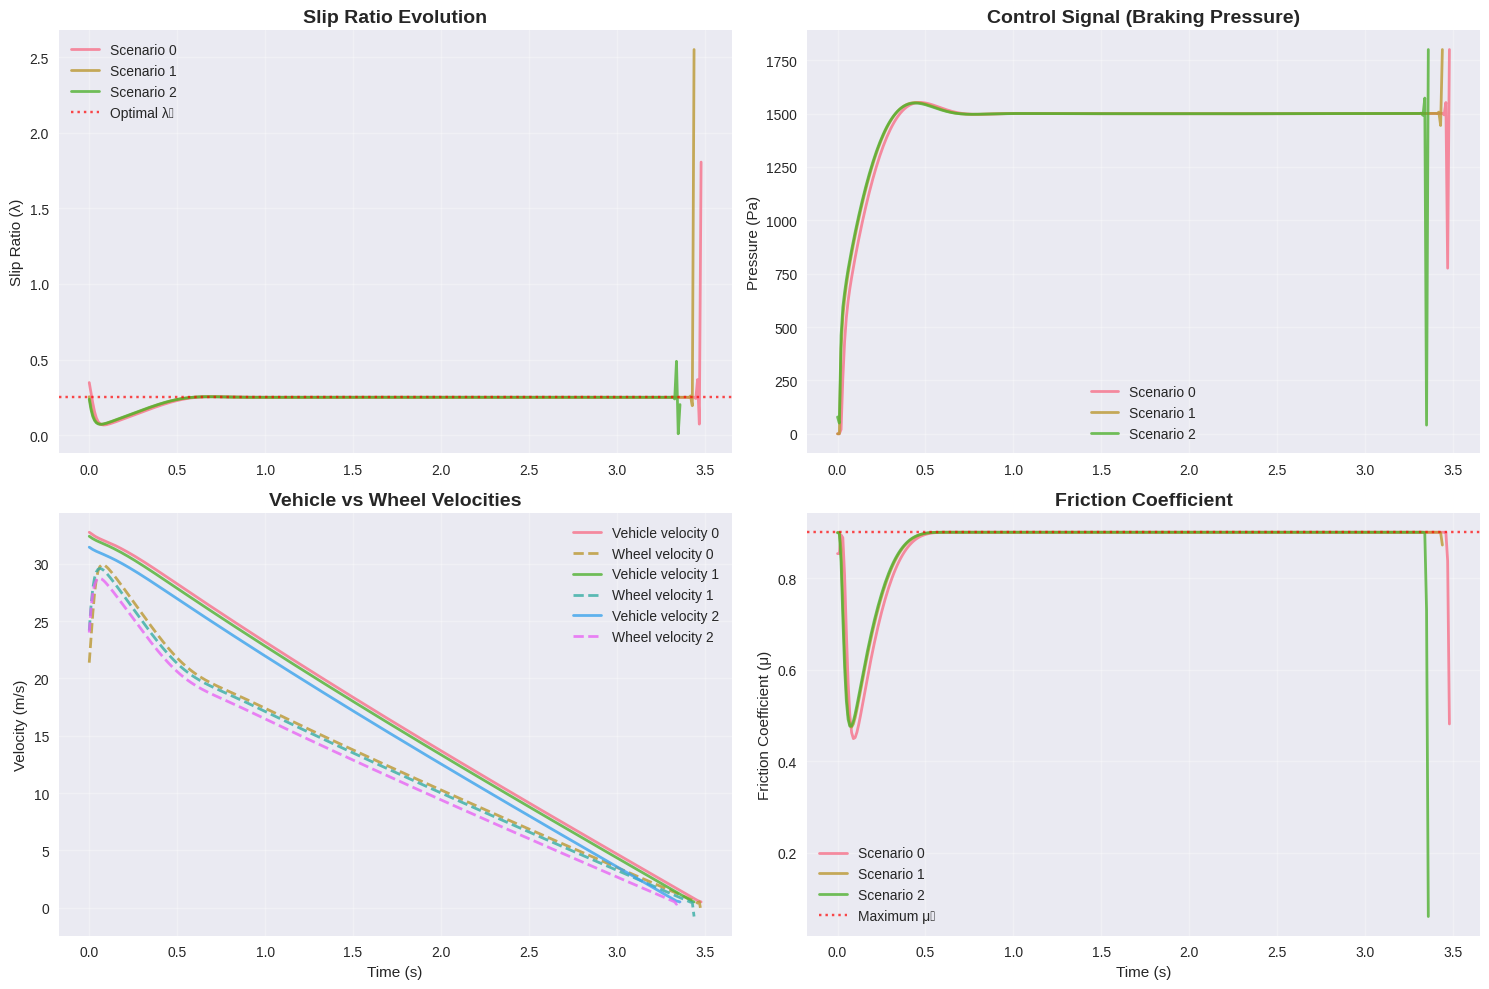

In [ ]:
def plot_sample_scenarios(df, n_scenarios=3):
    """Visualize sample scenarios from the generated data"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    for i in range(min(n_scenarios, 3)):
        scenario_data = df[df['scenario'] == i]

        # Slip ratio evolution
        axes[0,0].plot(scenario_data['time'], scenario_data['slip_ratio'],
                      label=f'Scenario {i}', alpha=0.8, linewidth=2)

        # Control signal
        axes[0,1].plot(scenario_data['time'], scenario_data['control_input'],
                      label=f'Scenario {i}', alpha=0.8, linewidth=2)

        # Velocities comparison
        axes[1,0].plot(scenario_data['time'], scenario_data['v'],
                      label=f'Vehicle velocity {i}', alpha=0.8, linewidth=2)
        axes[1,0].plot(scenario_data['time'], scenario_data['omega'] * simulator.r,
                      label=f'Wheel velocity {i}', alpha=0.8, linewidth=2, linestyle='--')

        # Friction coefficient
        axes[1,1].plot(scenario_data['time'], scenario_data['mu'],
                      label=f'Scenario {i}', alpha=0.8, linewidth=2)

    # Configure subplots
    axes[0,0].set_title('Slip Ratio Evolution', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Slip Ratio (λ)')
    axes[0,0].axhline(y=simulator.lambda0, color='red', linestyle=':', alpha=0.7,
                     label='Optimal λ₀')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    axes[0,1].set_title('Control Signal (Braking Pressure)', fontsize=14, fontweight='bold')
    axes[0,1].set_ylabel('Pressure (Pa)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    axes[1,0].set_title('Vehicle vs Wheel Velocities', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Velocity (m/s)')
    axes[1,0].set_xlabel('Time (s)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    axes[1,1].set_title('Friction Coefficient', fontsize=14, fontweight='bold')
    axes[1,1].set_ylabel('Friction Coefficient (μ)')
    axes[1,1].set_xlabel('Time (s)')
    axes[1,1].axhline(y=simulator.mu0, color='red', linestyle=':', alpha=0.7,
                     label='Maximum μ₀')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_sample_scenarios(training_data)

#### 3.4 Removing the Spikes
Because of the jump in the code, some spikes can appear and we will see it as aberrant values.

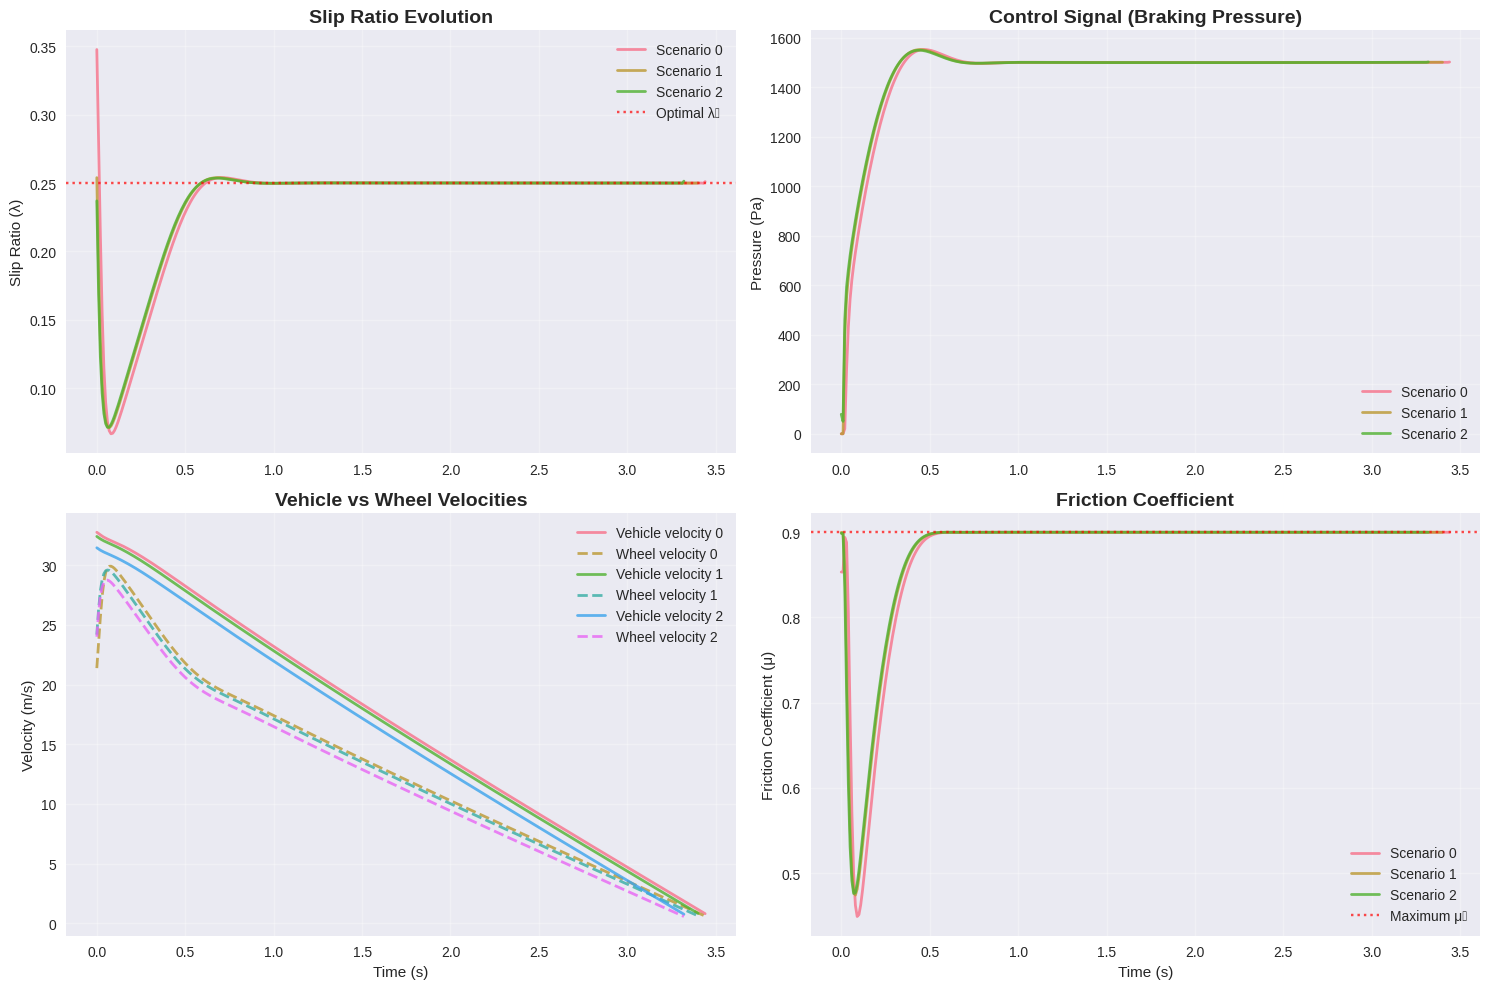

In [15]:
def trim_scenarios(df, n_tail=4):
    """
    Trim the last `n_tail` rows of each scenario to avoid slip ratio instability at the end.
    """
    trimmed_data = []
    for scenario_id in df['scenario'].unique():
        scenario_df = df[df['scenario'] == scenario_id]
        if len(scenario_df) > n_tail:
            trimmed_df = scenario_df.iloc[:-n_tail]
            trimmed_data.append(trimmed_df)
    return pd.concat(trimmed_data, ignore_index=True)

training_data_cleaned = trim_scenarios(training_data)
plot_sample_scenarios(training_data_cleaned, n_scenarios=3)

### 4. NARMA-L2 Controller Implementation
#### 4.1 Understanding the NARMA-L2 Training Strategy
The NARMA-L2 model from equation (14) in the paper is:
$y(k+d) = f(·) + g(·) \times u(k+1)$
This represents a nonlinear approximation of system behavior where:

- **f**: Nonlinear function depending on past outputs $y(k), y(k-1),...$ and past inputs $u(k), u(k-1),...$
- **g**: Function approximating system sensitivity to control input
- **u(k+1)**: Future control command, unknown during prediction but known during training with simulated data

The training strategy follows these steps:

- Step 1: Train g-network first (system sensitivity estimation): here we state that $g_k = (y[k+1] - y[k]) / (u[k+1] - u[k])$ in order to have some values to predict

- Step 2: Use g-network predictions to calculate corrected targets for f-network
- Step 3: Train f-network with corrected targets: $f_k = y(k+1) - g_k · u(k+1)$

Preparing training data...
Training data shape: (12810, 6)
Test data shape: (3203, 6)

Step 1: Training g-network (system sensitivity)...
Epoch 1/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0745 - val_loss: 0.0036
Epoch 2/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0041 - val_loss: 0.0022
Epoch 3/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 4/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 5/5
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8.6222e-04 - val_loss: 8.4403e-04

Step 2: Calculating corrected targets for f-network...
f-target statistics: mean=-147.5140, std=23.8412

Step 3: Training f-network...
Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.9325 - val_loss: 0.7732
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6405 - val_loss: 0.7030
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5357 - val_loss: 0.6514
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━

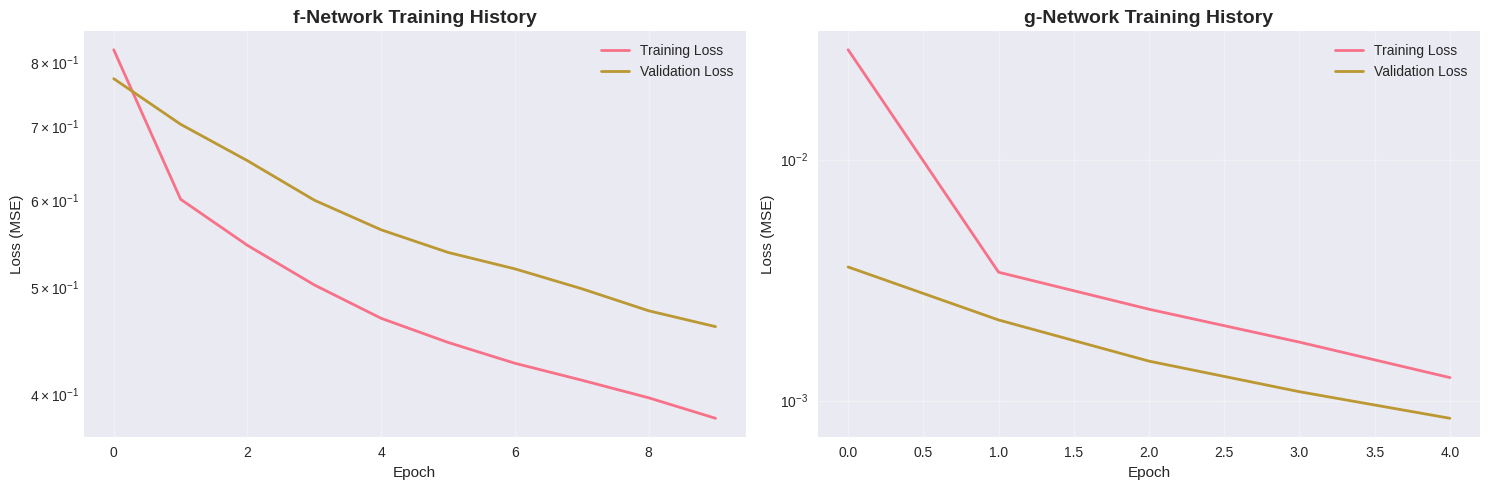

u(k+1) = 1506.17 Pa


In [16]:
class NARMAL2Controller:
    """
    NARMA-L2 Controller Implementation

    Based on the feedback linearization approach described in the paper.
    The controller uses two neural networks to approximate f and g functions
    in the NARMA model: y(k+d) = f(·) + g(·) · u(k+1)
    """

    def __init__(self, na=2, nb=2, d=1, hidden_neurons=5):
        """
        Initialize NARMA-L2 controller

        Parameters match paper specifications:
        - na=2: number of past outputs
        - nb=2: number of past inputs
        - d=1: system delay
        - hidden_neurons=5: as specified in paper
        """
        self.na = na
        self.nb = nb
        self.d = d
        self.hidden_neurons = hidden_neurons

        # Scalers for input/output normalization
        self.input_scaler = StandardScaler()
        self.output_scaler_f = StandardScaler()
        self.output_scaler_g = StandardScaler()

        # Neural networks (initialized as None)
        self.f_network = None
        self.g_network = None

        # Test data storage
        self.X_test = None
        self.y_test = None

    def _create_network(self, input_dim, output_dim=1):
        """
        Create neural network with specifications from the paper:
        - One hidden layer with 5 neurons
        - Tanh activation in hidden layer
        - Linear activation in output layer
        - Levenberg-Marquardt-like optimization (using Adam as approximation)
        """
        model = Sequential([
            layers.Dense(self.hidden_neurons, activation='tanh', input_shape=(input_dim,)),
            layers.Dense(output_dim, activation='linear')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse')
        return model

    def prepare_training_data(self, df):
        """
        Prepare training data for NARMA-L2 networks

        Creates input features: [y(k), y(k-1), y(k-2), u(k), u(k-1), u(k-2)]
        This matches the NARMA model structure from the paper
        """
        X, y_f, y_g, u_kplus1 = [], [], [], []

        for i in range(len(df) - self.d - 1):
            # Current and past slip ratios
            y_k = df.iloc[i]['slip_ratio']
            y_k1 = df.iloc[i]['slip_k_1']
            y_k2 = df.iloc[i]['slip_k_2']

            # Current and past control inputs
            u_k = df.iloc[i]['control_input']
            u_k1 = df.iloc[i]['control_k_1']
            u_k2 = df.iloc[i]['control_k_2']

            # Feature vector for both networks
            feature = [y_k, y_k1, y_k2, u_k, u_k1, u_k2]
            X.append(feature)

            # Future values (available during training)
            y_target = df.iloc[i + 1]['slip_ratio']  # y(k+1)
            u_next = df.iloc[i + 1]['control_input']  # u(k+1)

            y_f.append(y_target)  # Temporary f target
            u_kplus1.append(u_next)

            # Approximation g = dy/du
            """if abs(u_next - u_k) > 1e-6:  # Don't divide by 0
                g_value = (y_target - y_k) / (u_next - u_k)
            else:
                g_value = 0.0001

            g_value = np.clip(g_value, -0.01, 0.01)
            y_g.append(g_value)"""
            y_g.append(0.1)  # Initial g approximation

        return np.array(X), np.array(y_f), np.array(y_g), np.array(u_kplus1)

    def train(self, df, epochs=100, batch_size=32, test_size=0.2, verbose=1):
        """
        Train NARMA-L2 controller using the two-step process:
        1. Train g-network first
        2. Calculate corrected f targets and train f-network
        """

        print("Preparing training data...")
        X, y_f_raw, y_g, u_kplus1 = self.prepare_training_data(df)

        # Split data
        X_train, X_test, y_f_train, y_f_test, u_train, u_test, y_g_train, y_g_test = train_test_split(
            X, y_f_raw, u_kplus1, y_g, test_size=test_size, shuffle=False
        )

        # Scale inputs
        X_train_scaled = self.input_scaler.fit_transform(X_train)
        X_test_scaled = self.input_scaler.transform(X_test)

        print(f"Training data shape: {X_train_scaled.shape}")
        print(f"Test data shape: {X_test_scaled.shape}")

        # === STEP 1: Train g-network ===
        print("\nStep 1: Training g-network (system sensitivity)...")
        self.g_network = self._create_network(X_train.shape[1])
        y_g_train_scaled = self.output_scaler_g.fit_transform(np.array(y_g_train).reshape(-1, 1)).flatten()

        history_g = self.g_network.fit(
            X_train_scaled, y_g_train_scaled,
            epochs=epochs//2,
            batch_size=batch_size,
            verbose=verbose,
            validation_split=0.2
        )

        # === STEP 2: Calculate corrected f targets ===
        print("\nStep 2: Calculating corrected targets for f-network...")
        g_train_pred = self.g_network.predict(X_train_scaled, verbose=0).flatten()
        g_train_pred = self.output_scaler_g.inverse_transform(g_train_pred.reshape(-1, 1)).flatten()

        # Corrected f targets: f_k = y(k+1) - g_k * u(k+1)
        y_f_corrected = y_f_train - g_train_pred * u_train
        y_f_scaled = self.output_scaler_f.fit_transform(y_f_corrected.reshape(-1, 1)).flatten()

        print(f"f-target statistics: mean={np.mean(y_f_corrected):.4f}, std={np.std(y_f_corrected):.4f}")

        # === STEP 3: Train f-network ===
        print("\nStep 3: Training f-network...")
        self.f_network = self._create_network(X_train.shape[1])
        history_f = self.f_network.fit(
            X_train_scaled, y_f_scaled,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            validation_split=0.2
        )

        # Store test data for evaluation
        self.X_test = X_test_scaled
        self.y_test = y_f_test
        self.u_test = u_test

        print("\nNARMA-L2 training completed!")

        # Plot training histories
        self._plot_training_history(history_f, history_g)

        return history_f, history_g

    def _plot_training_history(self, history_f, history_g):
        """Plot training loss for both networks"""

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        # f-network training history
        ax1.plot(history_f.history['loss'], label='Training Loss', linewidth=2)
        ax1.plot(history_f.history['val_loss'], label='Validation Loss', linewidth=2)
        ax1.set_title('f-Network Training History', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss (MSE)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')

        # g-network training history
        ax2.plot(history_g.history['loss'], label='Training Loss', linewidth=2)
        ax2.plot(history_g.history['val_loss'], label='Validation Loss', linewidth=2)
        ax2.set_title('g-Network Training History', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss (MSE)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')

        plt.tight_layout()
        plt.show()

    def predict(self, X):
        X_scaled = self.input_scaler.transform(X)
        f_pred_scaled = self.f_network.predict(X_scaled, verbose=0)
        return self.output_scaler_f.inverse_transform(f_pred_scaled).flatten()

    def compute_control_input(self, current_state, reference_slip=0.25):
        if self.f_network is None or self.g_network is None:
            raise ValueError("Model not trained.")

        X_scaled = self.input_scaler.transform(current_state.reshape(1, -1))

        f_pred_scaled = self.f_network.predict(X_scaled, verbose=0)[0, 0]
        g_pred_scaled = self.g_network.predict(X_scaled, verbose=0)[0, 0]

        f_pred = self.output_scaler_f.inverse_transform([[f_pred_scaled]])[0, 0]
        g_pred = self.output_scaler_g.inverse_transform([[g_pred_scaled]])[0, 0]

        """if abs(g_pred) < 1e-6:
            g_pred = 1e-4 if g_pred >= 0 else -1e-4
        g_pred = np.clip(g_pred, -0.01, 0.01)  # To ensure no problem with division"""
        g_pred = max(g_pred, 0.05)  # To ensure no problem with division

        #print(f"f_pred={f_pred:.3f}, g_pred={g_pred:.3f}")

        # Compute control input
        u_next = (reference_slip - f_pred) / (g_pred + 1e-8)
        u_next = np.clip(u_next, 0, 1800)  # Apply physical limits

        return u_next

controller = NARMAL2Controller(hidden_neurons=5)
controller.train(training_data, epochs=10)

# Supposons une ligne d'entrée (état courant)
x_current = training_data.iloc[100][['slip_ratio', 'slip_k_1', 'slip_k_2',
                                'control_input', 'control_k_1', 'control_k_2']].values

u_next = controller.compute_control_input(np.array(x_current), reference_slip=0.25)
print(f"u(k+1) = {u_next:.2f} Pa")

#### 4.2 Verifying the NN output
The NARMA-L2 model is now trained so we can verify if the output matches our goal :

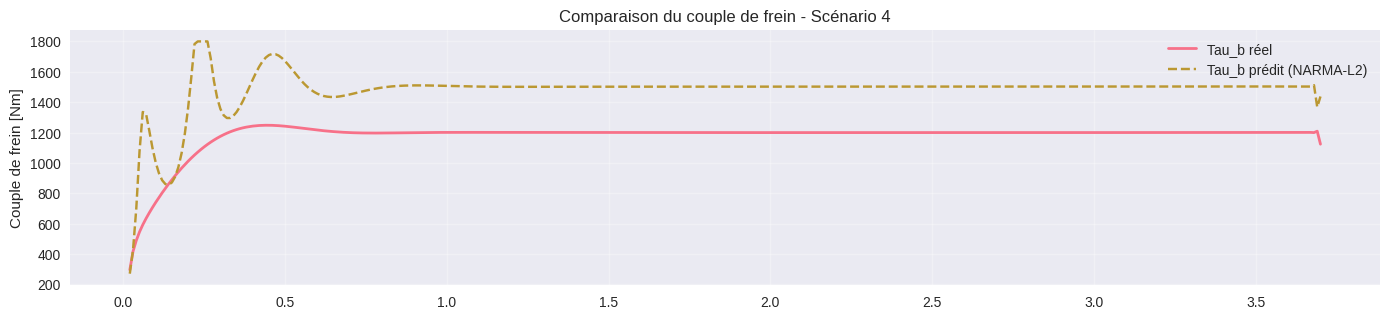

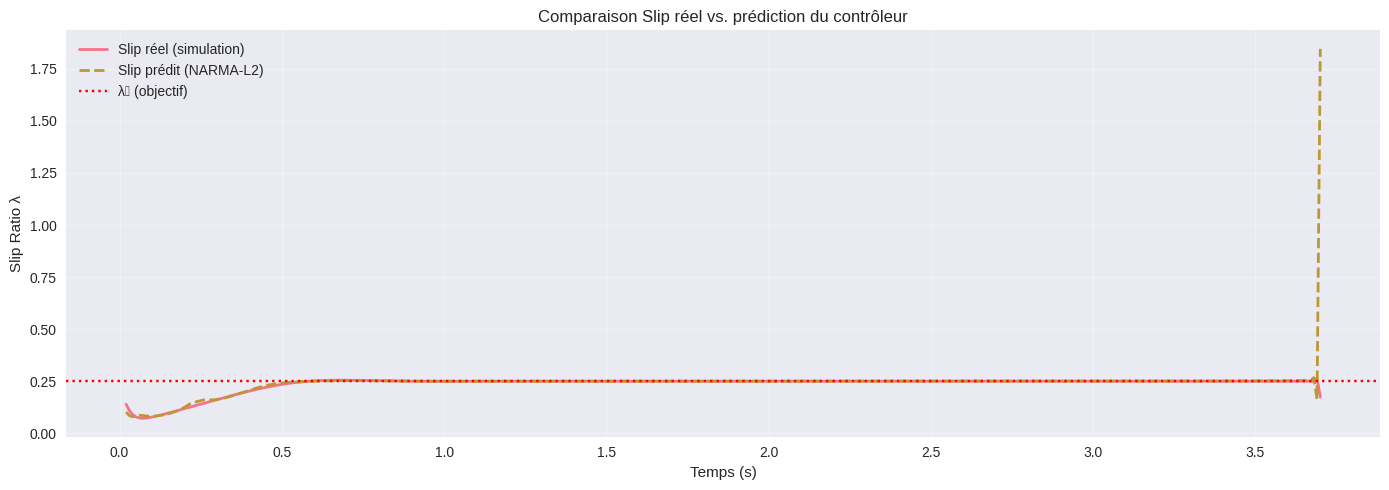

In [ ]:
# Select the scenario to test
scenario_id = 4
df_test = training_data[training_data['scenario'] == scenario_id].reset_index(drop=True)

# We will store the command predicted by the controller
tau_b_simulated = []
slip_predicted = []

# Loop through the data to simulate step by step
for i in range(2, len(df_test) - 1):  # Start at 2 to have y(k-2), u(k-2)
    # Construct x_current
    x_current = df_test.loc[i, ['slip_ratio', 'slip_k_1', 'slip_k_2',
                                'control_input', 'control_k_1', 'control_k_2']].values.astype(float)

    # Predict the command u(k+1)
    u_next = controller.compute_control_input(np.array(x_current), reference_slip=0.25)

    # Apply the command to the current state
    current_state = df_test.loc[i, ['omega', 'v', 'tau_b']].values.astype(float)
    t_span = [df_test.loc[i, 'time'], df_test.loc[i+1, 'time']]

    next_state = odeint(simulator.system_dynamics, current_state, t_span, args=(u_next,))[1]
    omega_next, v_next, _ = next_state

    # Compute the resulting λ
    if v_next > 0.1:
        lambda_next = (v_next - simulator.r * omega_next) / v_next
    else:
        lambda_next = 0

    slip_predicted.append(lambda_next)

    # Store the simulated command (brake pressure)
    tau_b_simulated.append(u_next)

# Adjust the length (since we started at i=2)
df_result = df_test.iloc[2:-1].copy().reset_index(drop=True)
df_result['tau_b_predicted'] = tau_b_simulated
df_result['lambda_predicted'] = slip_predicted

# === PLOTS ===
plt.figure(figsize=(14, 6))

# 1. Actual vs simulated brake torque
plt.subplot(2, 1, 1)
plt.plot(df_result['time'], df_result['tau_b'], label='Actual Tau_b', linewidth=2)
plt.plot(df_result['time'], df_result['tau_b_predicted'], label='Predicted Tau_b (NARMA-L2)', linestyle='--')
plt.ylabel("Brake torque [Nm]")
plt.title(f"Brake Torque Comparison - Scenario {scenario_id}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === Comparison of slip ratios (λ) ===

plt.figure(figsize=(14, 5))
plt.plot(df_result['time'], df_result['slip_ratio'], label='Actual Slip (simulation)', linewidth=2)
plt.plot(df_result['time'], df_result['lambda_predicted'], '--', label='Predicted Slip (NARMA-L2)', linewidth=2)
plt.axhline(y=simulator.lambda0, color='r', linestyle=':', label='λ₀ (target)')
plt.xlabel('Time (s)')
plt.ylabel('Slip Ratio λ')
plt.title('Comparison of Actual vs Controller Predicted Slip')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### 4.3 Comparison of Slip Regulation: NARMA-L2 vs PID

In [18]:
# === Simulation Parameters ===
duration = 3.0
dt = 0.01
steps = int(duration / dt)
time_points = np.arange(0, duration, dt)

# === Utility: Simulation Function ===
def run_simulation(controller, is_narma, label):
    # Initial vehicle state
    omega = 100  # initial wheel angular velocity
    v = 30       # initial vehicle speed
    tau_b = 0
    state = [omega, v, tau_b]

    # Histories
    slip_hist = [0.0, 0.0]
    control_hist = [0.0, 0.0]

    # Storage
    results = {
        'time': [],
        'slip_ratio': [],
        'control_input': [],
        'v': [],
        'omega': [],
        'tau_b': [],
        'label': label
    }

    for t in time_points:
        # Compute slip
        if v > 0.1:
            slip = (v - simulator.r * omega) / v
        else:
            slip = 0.0

        # Compute control input
        if is_narma:
            x_current = np.array([
                slip,
                slip_hist[-1],
                slip_hist[-2],
                control_hist[-1],
                control_hist[-2],
                0.0
            ])
            u_next = controller.compute_control_input(x_current, reference_slip=0.25)
        else:
            error = 0.25 - slip
            u_next = controller.compute(error)

        # Update dynamics
        next_state = odeint(simulator.system_dynamics, state, [t, t + dt], args=(u_next,))[1]
        omega, v, tau_b = next_state
        state = [omega, v, tau_b]

        # Update histories
        slip_hist.append(slip)
        control_hist.append(u_next)
        slip_hist = slip_hist[-3:]
        control_hist = control_hist[-3:]

        # Store results
        results['time'].append(t)
        results['slip_ratio'].append(slip)
        results['control_input'].append(u_next)
        results['v'].append(v)
        results['omega'].append(omega)
        results['tau_b'].append(tau_b)

        if v < 0.5:
            break

    return results

# === Create PID Controller ===
pid_controller = PIDController(Kp=3000, Ti=0.1, Td=0.01, alpha=0.1, dt=dt)

# === Run Both Simulations ===
results_narma = run_simulation(controller, is_narma=True, label="NARMA-L2")
results_pid = run_simulation(pid_controller, is_narma=False, label="PID")

Plot the results

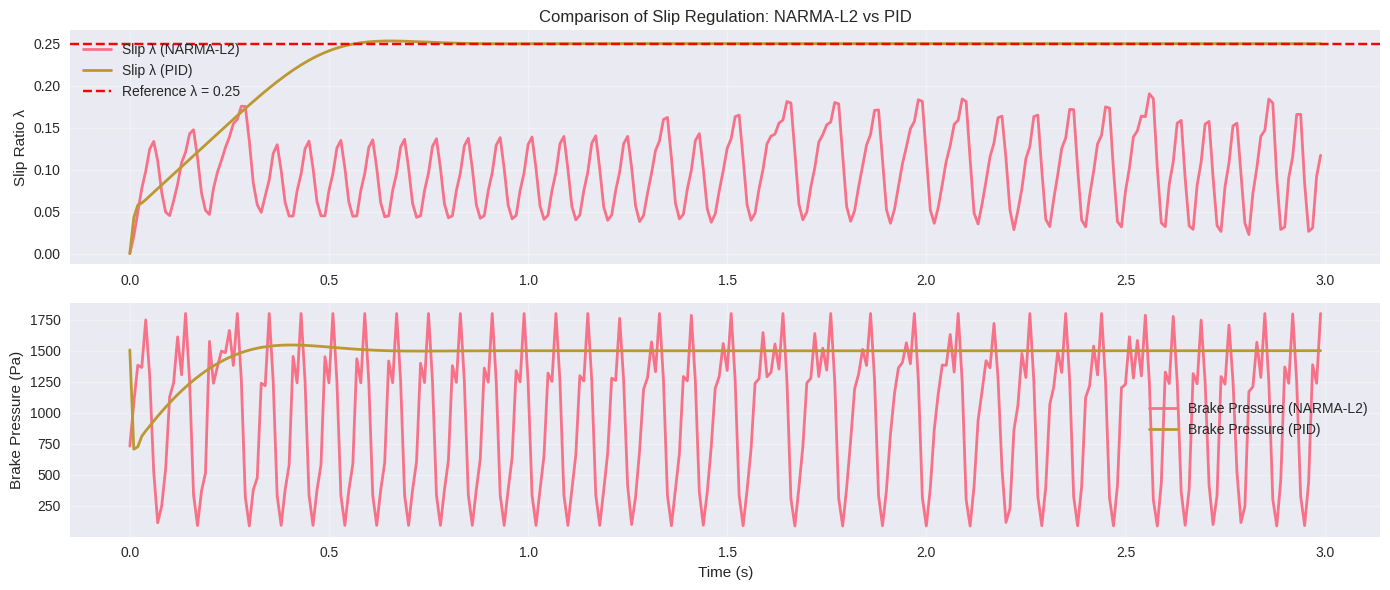

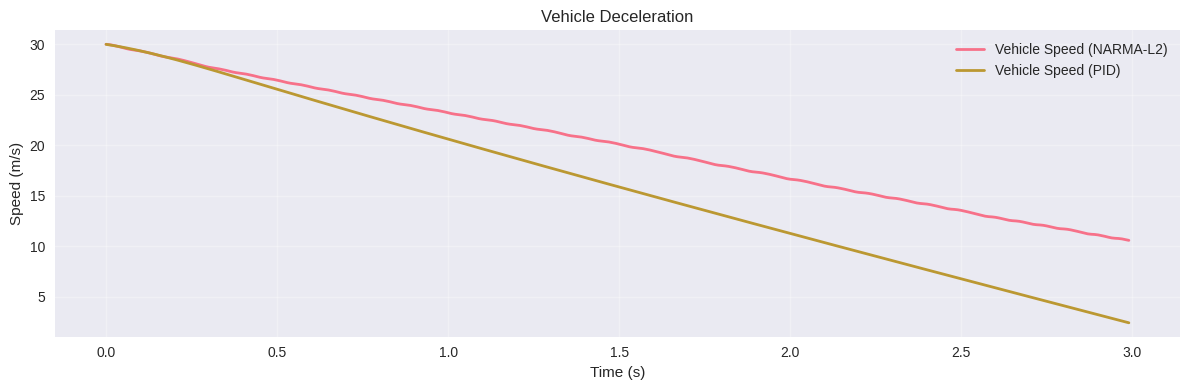

In [19]:
# === Plotting ===
def plot_comparison(results_list):
    plt.figure(figsize=(14, 6))

    # Slip ratio comparison
    plt.subplot(2, 1, 1)
    for res in results_list:
        plt.plot(res['time'], res['slip_ratio'], label=f"Slip λ ({res['label']})", linewidth=2)
    plt.axhline(y=0.25, color='r', linestyle='--', label="Reference λ = 0.25")
    plt.ylabel("Slip Ratio λ")
    plt.title("Comparison of Slip Regulation: NARMA-L2 vs PID")
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Brake pressure comparison
    plt.subplot(2, 1, 2)
    for res in results_list:
        plt.plot(res['time'], res['control_input'], label=f"Brake Pressure ({res['label']})", linewidth=2)
    plt.ylabel("Brake Pressure (Pa)")
    plt.xlabel("Time (s)")
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Vehicle speed comparison
    plt.figure(figsize=(12, 4))
    for res in results_list:
        plt.plot(res['time'], res['v'], label=f"Vehicle Speed ({res['label']})", linewidth=2)
    plt.ylabel("Speed (m/s)")
    plt.xlabel("Time (s)")
    plt.title("Vehicle Deceleration")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# === Compare Results ===
plot_comparison([results_narma, results_pid])